In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import gcm_filters
import numpy as np

In [2]:
prog = xr.open_mfdataset([
    '/home/ras003/dev/gfdl/MOM6-examples/ocean_only/Phillips_2layer_ER/prog__0002.nc'],    
    use_cftime = True)
energy = xr.open_mfdataset([    
    '/home/ras003/dev/gfdl/MOM6-examples/ocean_only/Phillips_2layer_ER/energy__0002.nc'],
    use_cftime = True)
grid = xr.open_dataset('/home/ras003/dev/gfdl/MOM6-examples/ocean_only/Phillips_2layer_ER/ocean_static.nc')

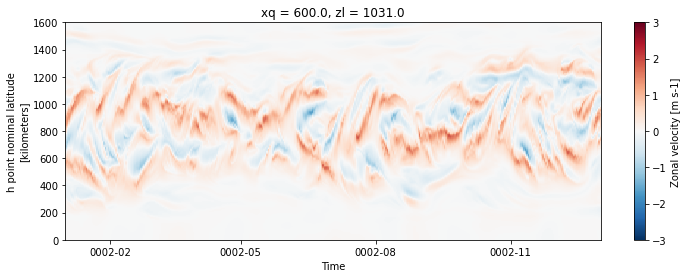

In [3]:
plt.figure(figsize=(12,4))
prog.u.isel(zl=0,xq=120).transpose().plot(vmin=-3,vmax=3,cmap=plt.cm.RdBu_r)

## Interpolate staggered fields to the center 'T' point

Various quantities of the model 'live' on a different grids due to the finite volume discretization used in MOM6. https://en.wikipedia.org/wiki/Arakawa_grids. We first do a linear interpolation to ensure that all the quantities are referenced to the same point.

In [4]:
u_T = prog.u.interp(xq=prog.xh.values).swap_dims( xq='xh' )
v_T = prog.v.interp(yq=prog.yh.values).swap_dims( yq='yh' )
RV_T = prog.RV.interp(yq=prog.yh.values,xq=prog.xh.values).swap_dims( yq='yh', xq='xh' )

In [29]:
# Coarsen to the low resolution model (4x coarser)
coarsen_factor = 16
coarsen_opts = dict( xh=coarsen_factor, yh=coarsen_factor )
u_coarse = u_T.coarsen(**coarsen_opts).mean()
v_coarse = v_T.coarsen(**coarsen_opts).mean()

Text(0.5, 1.0, 'Coarsened (x4)')

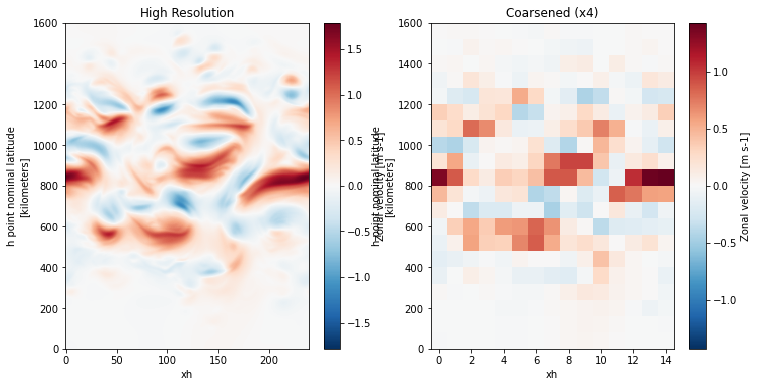

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
u_T.isel(zl=0,Time=0).plot()
plt.title('High Resolution')
plt.subplot(1,2,2)
u_coarse.isel(zl=0,Time=0).plot()
plt.title('Coarsened (x4)')

In [31]:
# Calculate the 'eddy' velocities
u_eddy = u_coarse - u_coarse.mean('Time')
v_eddy = u_coarse - u_coarse.mean('Time')

Text(0.5, 1.0, 'Eddy flow')

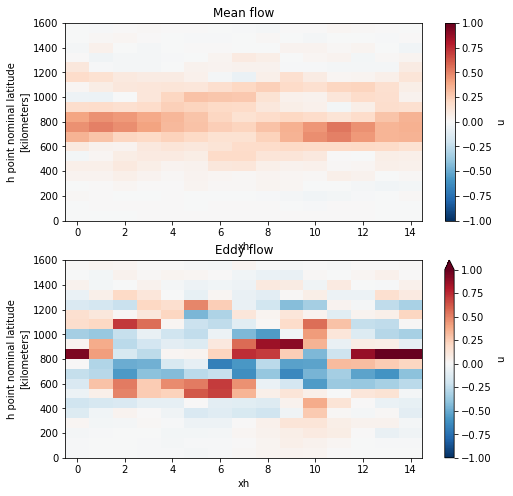

In [32]:
vel_opts = dict(
    vmin=-1,
    vmax=1,
    cmap=plt.cm.RdBu_r
)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
u_coarse.mean('Time').isel(zl=0).plot(**vel_opts)
plt.title('Mean flow')
plt.subplot(2,1,2)
u_eddy.isel(Time=0).isel(zl=0).plot(**vel_opts)
plt.title('Eddy flow')

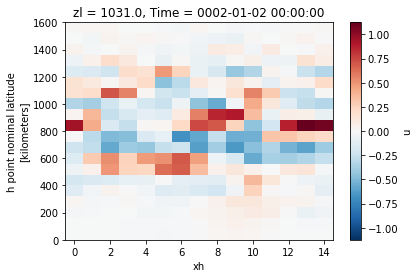

In [33]:
eddy_kinetic_energy = 0.5*(u_eddy+v_eddy).isel(zl=0)
eddy_kinetic_energy.isel(Time=0).plot()

## Calculate the predictands

### Mean Kinetic Energy
$\textrm{MKE} = \frac{1}{2}(\bar{u}^2 + \bar{v}^2)$, where $\bar{u}$ and $\bar{v}$ is time invariant

### Isopycnal Slope
The model used here is discretized in the vertical on isopycnal coordinates. Hence the isopycnal slope is just the slope of the interface between layers 1 and 2 of the model

### Relative vorticity
Relative vorticty is the curl of the velocity fields. This is a quantity already calculated from the model

### Rossby Radius/Grid Spacing
This is the ratio between the largest scale of turbulence (determined by the Rossby Radius) and the nominal grid spacing. If this ratio is about 4, then the eddies are well-resolved. The base quantity is calculated from the model, but must be handled correctly when coarsening the fields


In [34]:
# Calculate features
# Mean Kinetic Energy
mean_kinetic_energy = energy.KE.mean('Time').coarsen(**coarsen_opts).mean().isel(zl=0)
surface_relative_vorticity = RV_T.coarsen(**coarsen_opts).mean().isel(zl=0)

slope_x = prog.e.isel(zi=1).coarsen(**coarsen_opts).mean().differentiate('xh',edge_order=2)
slope_y = prog.e.isel(zi=1).coarsen(**coarsen_opts).mean().differentiate('yh',edge_order=2)
isopycnal_slope = xr.ufuncs.fabs(slope_x) + xr.ufuncs.fabs(slope_y)
Rd_dx = prog.Rd_dx.coarsen(**coarsen_opts).mean()/coarsen_opts['xh']


In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
mean_kinetic_energy.plot()
plt.title('MKE')
plt.subplot(2,2,2)
surface_relative_vorticity.isel(Time=0).plot()
plt.title('Relative Vorticity')
plt.subplot(2,2,3)
isopycnal_slope.isel(Time=0).plot()
plt.title('Isopycnal Slope')
plt.subplot(2,2,4)
Rd_dx.isel(Time=0).plot()
plt.title('Rossby Radius/Grid Spacing')


Text(0.5, 1.0, 'Rossby Radius/Grid Spacing')